<center> <h1> Tabular Playground Series - Jan 2022  </h1> </center> 

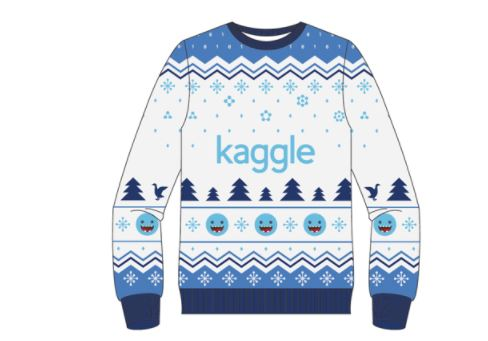

<h2 style='background:#11489c; border:0; color:white'><center>Overview</center></h2>
There are two (fictitious) independent store chains selling Kaggle merchandise that want to become the official outlet for all things Kaggle.  we want to figure out which of the store chains(KaggleMart or KaggleRama) would have the best sales going forward. 


<h2 style='background:#11489c; border:0; color:white'><center>About the data</center></h2>

For this challenge, we will be predicting a full year worth of sales for three items at two stores located in three different countries. This dataset is completely fictional, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. The dataset is small enough to allow us to try numerous different modeling approaches.

**Files**
- **train.csv** - the training set, which includes the sales data for each date-country-store-item combination.
- **test.csv**- the test set; your task is to predict the corresponding item sales for each date-country-store-item combination. Note the Public leaderboard is scored on the first quarter of the test year, and the Private on the remaining.
- **sample_submission.csv** - a sample submission file in the correct format

<h2 style='background:#11489c; border:0; color:white'><center>Notebook Set up</center></h2>

In [259]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import plotly
import plotly.express as px
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit ,train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import plot_tree
from datetime import datetime
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
import warnings
warnings.filterwarnings('ignore')

print("Packages Imported ")


Packages Imported 


#### data loiding 

In [260]:
## import data 
train = pd.read_csv("../input/tabular-playground-series-jan-2022/train.csv",index_col="row_id")
test = pd.read_csv("../input/tabular-playground-series-jan-2022/test.csv",index_col="row_id")
sample = pd.read_csv("../input/tabular-playground-series-jan-2022/sample_submission.csv")

<h2 style='background:#11489c; border:0; color:white'><center> Exploratory Data Analysis </center></h2>

Before going any further we want to look at our data frames and see what can that provide us ( insights , ideas ). 

### Train Data 

In [261]:
train.head(4)

,date,country,store,product,num_sold
row_id,,,,,
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572


**Genral info about the data** 

In [262]:
train.info()
train.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26298 entries, 0 to 26297
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      26298 non-null  object
 1   country   26298 non-null  object
 2   store     26298 non-null  object
 3   product   26298 non-null  object
 4   num_sold  26298 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


(26298, 5)

In [263]:
train.isnull().sum()

date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

The train data has 26298 rows and 5 columns with no missing values ( we are happy with that ) , all the columns are object type except number sold (our target)  is an int64 type.

In [264]:
start_date =train.date.min()
end_date = train.date.max()
start_date , end_date

('2015-01-01', '2018-12-31')

The train data cover a period of 4 years starting from 01-01-2015 and ending on 31-12-2018.

### Values counts of country , stores and kaggle products.

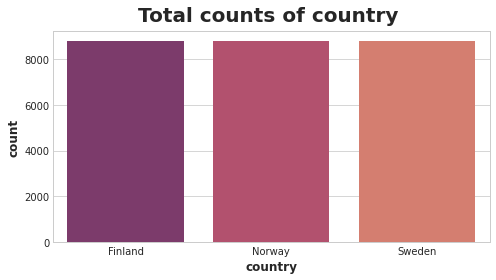

In [265]:
plt.figure(figsize=(7, 4))
sns.countplot(x='country', data=train, order=train["country"].value_counts().index[:3],palette = "flare_r")
plt.title("Total counts of country ", size=20)
plt.show()

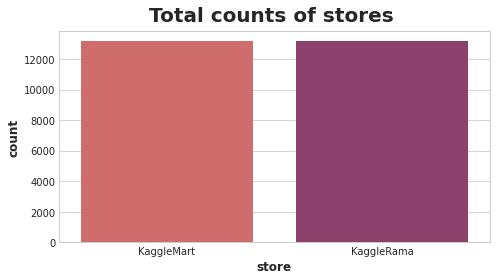

In [266]:
plt.figure(figsize=(7, 4))
sns.countplot(x='store', data=train, order=train["store"].value_counts().index[:2],palette = "flare")
plt.title("Total counts of stores ", size=20)
plt.show()

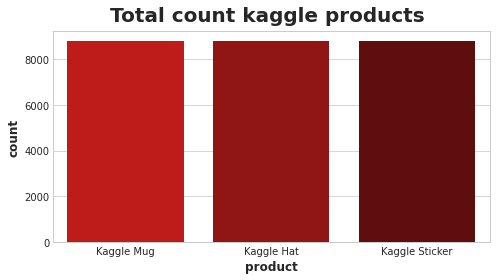

In [267]:
plt.figure(figsize=(7, 4))
sns.countplot(x='product', data=train, order=train["product"].value_counts().index[:3],palette = "flag")
plt.title("Total count kaggle products ", size=20)
plt.show()

Looking at returned plots we can tel that all variables are equally present with in the train data.

### Total number sold over time 

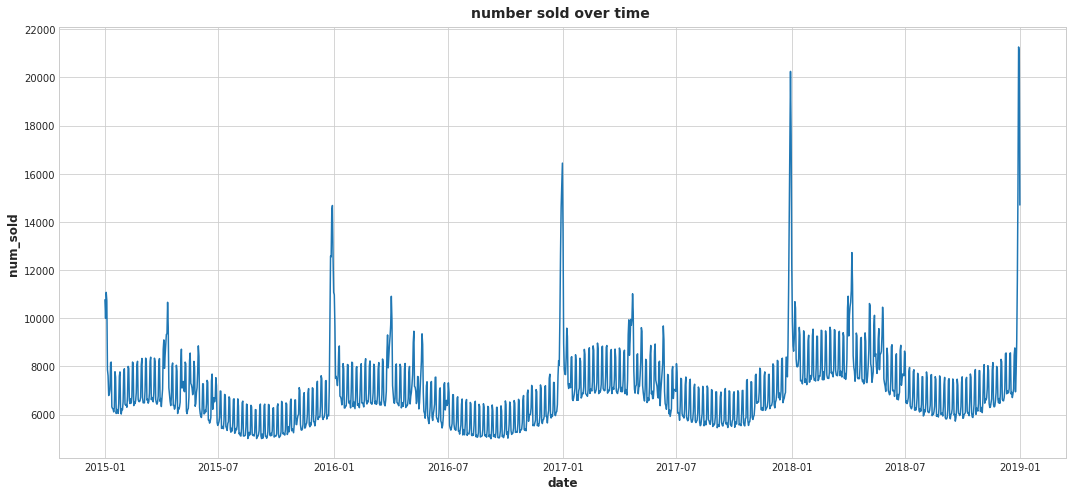

In [268]:
train['date'] = pd.to_datetime(train['date'], format='%Y/%m/%d')
plt.figure(figsize=(15,7))
sld_time = train.groupby(['date']).sum().reset_index()
sns.lineplot(x=sld_time.date, y=sld_time.num_sold,)
plt.title('number sold over time ', fontsize=14)
plt.show()


we need to look deeper before making conclusions but it's quite clear that the number sold increases on April an December  for each year( holydays shoppings ).

#### Number sold for each country 

Text(0.5, 1.0, 'Number sold by country')

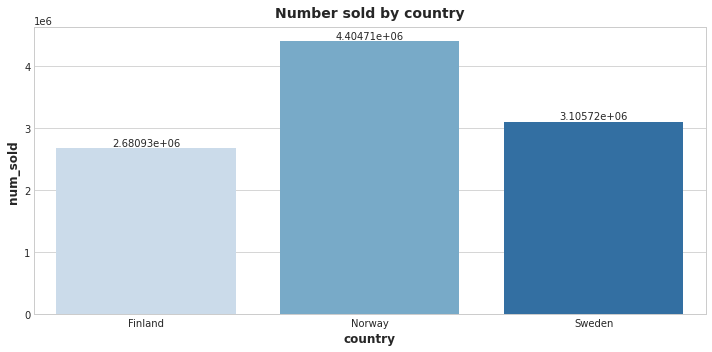

In [269]:
sld_cont = train.groupby(['country']).sum().reset_index()
plt.figure(figsize=(10,5))
ax = sns.barplot(x="country", y='num_sold', data=sld_cont, palette="Blues")
ax.bar_label(ax.containers[0])
ax.set_title('Number sold by country',
             fontsize = 14)

Looking at the figure above we can see that norway has the most number sold , followed by sweden then finland.

Text(0.5, 1.0, 'Number sold in each store')

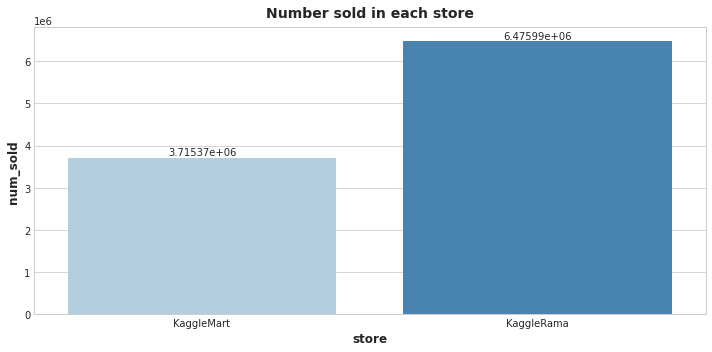

In [270]:
sld_store = train.groupby(['store']).sum().reset_index()
plt.figure(figsize=(10,5))
ax = sns.barplot(x="store", y='num_sold', data=sld_store, palette="Blues")
ax.bar_label(ax.containers[0])
ax.set_title('Number sold in each store',
             fontsize = 14)

We can see that kaggleRama had almost twice the number of solds comparing to kaggleMart.

#### Total sold of each Product across all countries.

Text(0.5, 1.0, 'Number sold of each product')

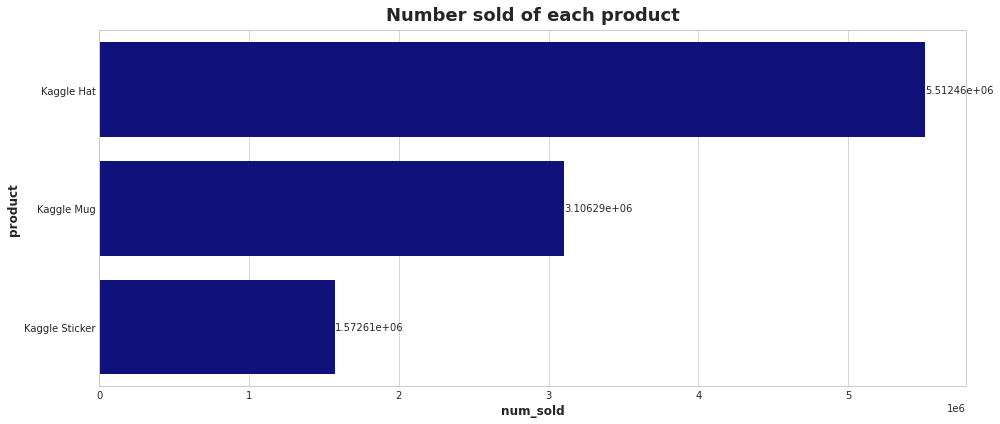

In [271]:
sld_item= train.groupby(['product']).sum().reset_index()
plt.figure(figsize=(14,6))
ax = sns.barplot(x="num_sold", y='product', data=sld_item,color="darkblue")
ax.bar_label(ax.containers[0])
ax.set_title('Number sold of each product', fontsize = 18) 

We can see that kaggle Hat (how cute is it) are most popular product followed by kaggle Mugs then kaggle Strickers.

### Year, month and day trends 

We want to know how number sold evolved over the year , month and day , for that we need to creat extra features using the date column.

In [272]:
##add time features 
train['year']=train['date'].dt.year 
train['month']=train['date'].dt.month_name()
train['day']=train['date'].dt.day_name()
train.head(3)

,date,country,store,product,num_sold,year,month,day
row_id,,,,,,,,
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329,2015,January,Thursday
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520,2015,January,Thursday
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146,2015,January,Thursday


In [273]:
### plotdata preparation
sld_year = train.groupby(['year']).mean().reset_index()
sld_month = train.groupby(['month']).mean().reset_index().set_index('month')
sld_day = train.groupby(['day']).mean().reset_index().set_index('day')
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sld_month= sld_month.reindex(new_order, axis=0)
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
sorterIndex = dict(zip(sorter,range(len(sorter))))
sld_day['Day_id'] = sld_day.index
sld_day['Day_id'] = sld_day['Day_id'].map(sorterIndex)
sld_day.sort_values('Day_id', inplace=True)

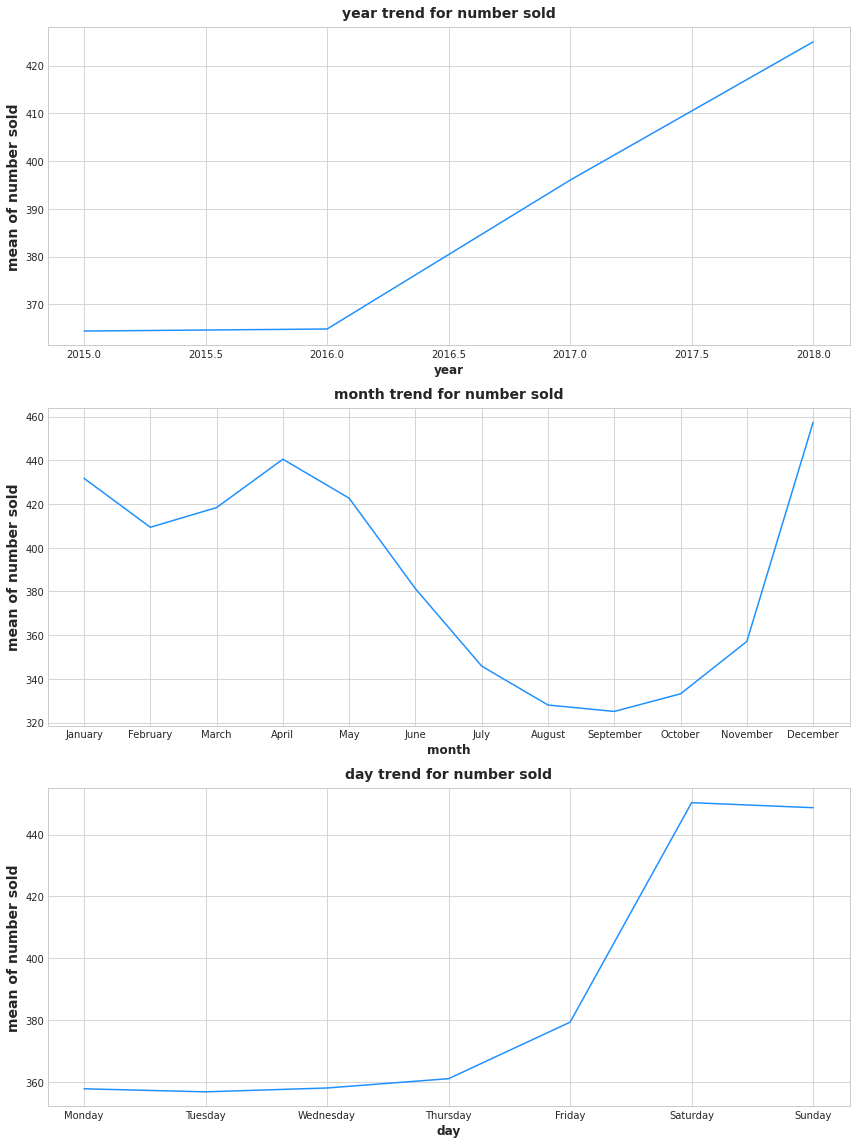

In [274]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 16))
sns.lineplot(x=sld_year.year, y=sld_year.num_sold ,ax=ax[0], color='dodgerblue')
ax[0].set_title('year trend for number sold', fontsize=14)
ax[0].set_ylabel(ylabel='mean of number sold', fontsize=14)

sns.lineplot(x="month", y=sld_month.num_sold,data= sld_month , ax=ax[1], color='dodgerblue')
ax[1].set_title('month trend for number sold', fontsize=14)
ax[1].set_ylabel(ylabel='mean of number sold', fontsize=14)

sns.lineplot(x="day", y=sld_day.num_sold, data = sld_day , ax=ax[2], color='dodgerblue')
ax[2].set_title('day trend for number sold', fontsize=14)
ax[2].set_ylabel(ylabel='mean of number sold', fontsize=14)

plt.show()

Looking at the three plots above we can see that number sold start increasing after 2016. we have two peaks ( around april and november )  where end of the year ( november and december ) is the period where number of solds reach it's maximun and while august and sepetemer saw the least number solds. on a daily basis we see that solds increases significantly on saturday and saunday ( weekend days ).

Let's now check the number of solds in each country.

In [275]:
plt1= train.groupby(['country','year'])['num_sold'].sum().reset_index()
fig = px.line(plt1, x="year", y="num_sold", title= " total number sold by year in each country",color="country", markers=True)
fig.show()

In [276]:
plt2= train.groupby(['country','month'])['num_sold'].sum().reset_index()
#plt2.reset_index(inplace=True)   
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
plt2['time'] = pd.Categorical(plt2['month'], categories=months, ordered=True)
plt2 = plt2.sort_values(['time','num_sold'], ascending= [True,False])
fig = px.line(plt2, x="time", y="num_sold", title= "Number sold products by month in each country",color="country", markers=True)
fig.show()


In [277]:
plt4= train.groupby(['country','day'])['num_sold'].sum().reset_index().set_index('day')
plt4['Day_id'] = plt4.index
plt4['Day_id'] = plt4['Day_id'].map(sorterIndex)
plt4.sort_values('Day_id', inplace=True)
fig = px.line(plt4, x=plt4.index, y="num_sold", title= "Total daily sold products in each country",color="country", markers=True)
fig.show()

It's clear that all three countries follow the same trend ( yearly , monthly , and daily ).

let's check Now how the number of solds for each products evolved over monthes.

In [278]:
plt3= train.groupby(['month','product'])['num_sold'].sum().reset_index()
plt3['time'] = pd.Categorical(plt3['month'], categories=months, ordered=True)
plt3 = plt3.sort_values(['time','num_sold'], ascending= [True,False])
fig = px.line(plt3, x="month", y="num_sold",title= "Total monthly solds for each products",color="product", markers=True)
fig.show()

Same for products,the number solds follow almost the same trend.

#### Evolution of number of sales for each product in diffrent countries

In [279]:
plt5= train.groupby(['date','country','product'])['num_sold'].sum().reset_index()
plt5 = plt5.sort_values(['date','num_sold'], ascending= [True,False])
sel_nor = plt5.loc[plt5['country'] == 'Norway']
fig = px.line(sel_nor, x="date", y="num_sold",title= "Evolution of number of sales for each product in Norway",color="product")
sel_swed = plt5.loc[plt5['country'] == 'Sweden']
fig.show()
fig = px.line(sel_swed, x="date", y="num_sold",title= "Evolution of number of sales for each product in Sweden",color="product")
fig.show()
sel_finla = plt5.loc[plt5['country'] == 'Sweden']
fig = px.line(sel_finla, x="date", y="num_sold",title= "Evolution of number of sales for each product in Finland",color="product")
fig.show()

#### Evolution of number of sales for each product in diffrent countries

In [280]:
plt6= train.groupby(['date','country','store'])['num_sold'].sum().reset_index()
plt6 = plt6.sort_values(['date','num_sold'], ascending= [True,False])
sel_nor = plt6.loc[plt5['country'] == 'Norway']
fig = px.line(sel_nor, x="date", y="num_sold",title= "Evolution of number of sales by each store in Norway",color="store")
sel_swed = plt6.loc[plt5['country'] == 'Sweden']
fig.show()
fig = px.line(sel_swed, x="date", y="num_sold",title= "Evolution of number of sales by each store in Sweden",color="store")
fig.show()
sel_finla = plt6.loc[plt5['country'] == 'Sweden']
fig = px.line(sel_finla, x="date", y="num_sold",title= "Evolution of number of sales by each store in Finland",color="store")
fig.show()

### Test data 


In [281]:
test.head(4)

,date,country,store,product
row_id,,,,
26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
26301,2019-01-01,Finland,KaggleRama,Kaggle Mug


#### Genral info about test data 

In [282]:
test.info()
test.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6570 entries, 26298 to 32867
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     6570 non-null   object
 1   country  6570 non-null   object
 2   store    6570 non-null   object
 3   product  6570 non-null   object
dtypes: object(4)
memory usage: 256.6+ KB


(6570, 4)

In [283]:
test.isnull().sum()

date       0
country    0
store      0
product    0
dtype: int64

In [284]:
start_dt_ts =test.date.min()
end_dt_ts = test.date.max()
start_dt_ts , end_dt_ts

('2019-01-01', '2019-12-31')

the test data comes with 6570 rows , 4 columns ( right ) and no missing values. the test data covers the next 12 months afeter train data ( from 1-1-2019 to 31-12-2019 ) 

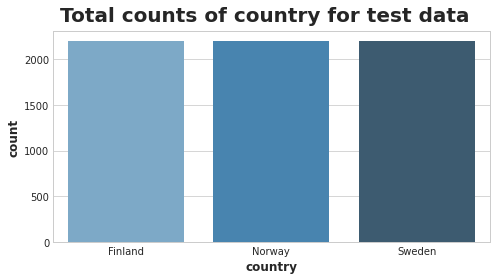

In [285]:
plt.figure(figsize=(7, 4))
sns.countplot(x='country', data=test, order=test["country"].value_counts().index[:3],palette = "Blues_d")
plt.title("Total counts of country for test data  ", size=20)
plt.show()

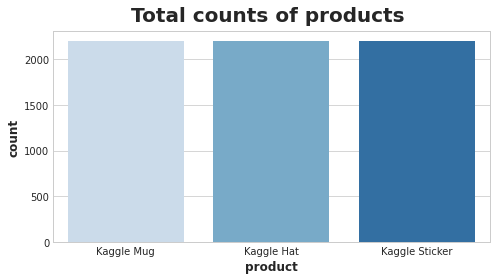

In [286]:
plt.figure(figsize=(7, 4))
sns.countplot(x='product', data=test, order=test["product"].value_counts().index[:3],palette = "Blues")
plt.title("Total counts of products ", size=20)
plt.show()

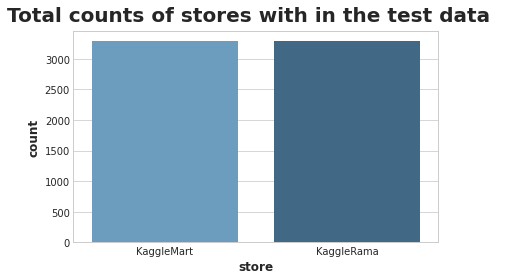

In [287]:
plt.figure(figsize=(6, 4))
sns.countplot(x='store', data=test, order=test["store"].value_counts().index[:2],palette ="Blues_d")
plt.title("Total counts of stores with in the test data  ", size=20)
plt.show()

Same as in the train data , country , product and store are equally present with in the test data. before going further lets as add the same features we added to the train data.

In [288]:
##add time features 
test['date'] = pd.to_datetime(test['date'], format='%Y/%m/%d')
test['year']=test['date'].dt.year 
test['month']=test['date'].dt.month_name()
test['day']=test['date'].dt.day_name()

 <h2 style='background:#11489c; border:0; color:white'><center> time series frocasting</center></h2>
 
 After we did some exploration for our data , now it's time to model it in order to predict future sales. For that we are going to use , in first verions i was using lightautoMl which is a general perpous tabular autoML ( didn't spend time tuning on it). for this time i'am exprimnting with a simple model ( may that change ) , Note the perpous of this notebook is to provide a general workflow for TS forcasting. 

#### Data preparation 

In [289]:
train_df= train.copy()
test_df = test.copy()

In [290]:
#ddd extra features 
train_df["is_weekend"]= train_df.day.apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)
train_df['dayofweek'] = train_df['date'].dt.dayofweek
#train_df['dayofyear'] = train_df['date'].dt.dayofyear
#train_df['dayofmonth'] = train_df['date'].dt.days_in_month
train_df['Time_step'] = np.arange(len(train_df.index)) # add a time step feature
#train['weekday'] = train['date'].dt.weekday
##test
test_df["is_weekend"]= test_df.day.apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)
test_df['dayofweek'] = test_df['date'].dt.dayofweek
test_df['Time_step'] = np.arange(len(test_df.index))
#test_df['dayofyear'] = test_df['date'].dt.dayofyear
#test_df['dayofmonth'] = test_df['date'].dt.days_in_month

#test['weekday'] = test['date'].dt.weekday

In [291]:
#train_df.set_index("date")
#test_df.set_index("date")

In [292]:
##label encoder for categorical features
le = LabelEncoder()
cols = [ "country","product","store","month","day" ,"year"]
for col in cols :
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.fit_transform(test_df[col])

In [293]:
#train_valid_split 
X_train = train_df[train_df.date.between('2015-01-01', '2018-5-31')].copy()
X_val = train_df[train_df.date.between('2018-06-01', '2018-12-31')].copy()

In [294]:
# remove date col 
X_train = X_train.drop("date",axis=1)
X_val = X_val.drop("date",axis=1)
test_df= test_df.drop("date",axis=1)

In [295]:
y_train=X_train["num_sold"]
X_train = X_train.drop("num_sold",axis=1)
y_val= X_val["num_sold"]
X_val= X_val.drop("num_sold",axis=1)

#### Train and evaluation of base model 

In [296]:
baseline_regressor = RandomForestRegressor(n_estimators=500,n_jobs=-1) # some rondom paramaters 
baseline_regressor.fit(X_train, y_train)
val_pred= baseline_regressor.predict(X_val)

In [297]:
# thanks to https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298201
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [298]:
print('The SMAPE value of the Random Forests model is :\t',SMAPE(val_pred,y_val))

The SMAPE value of the Random Forests model is :	 13.115846283673786


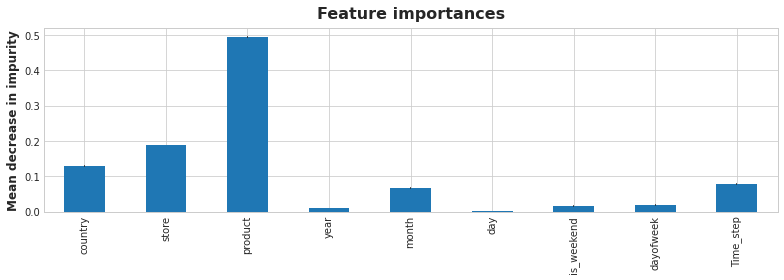

In [299]:
importance = baseline_regressor.feature_importances_ # get feature importance 
feature_names = list(X_train.columns)# get feature names 
std = np.std([tree.feature_importances_ for tree in baseline_regressor.estimators_], axis=0)
baseline_importances = pd.Series(importance, index=feature_names) # convert to pandas serie 
# plot 
fig, ax = plt.subplots() 
baseline_importances.plot.bar(xerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Predictions 

In [300]:
test_pred = baseline_regressor.predict(test_df)

#### Submission 

In [301]:
sample["num_sold"] = test_pred
sample.to_csv("baseliner.csv",index=False)
sample.head()

,row_id,num_sold
0,26298,306.558
1,26299,496.760
2,26300,134.676
3,26301,536.132
4,26302,841.864


#### prediction analysis 

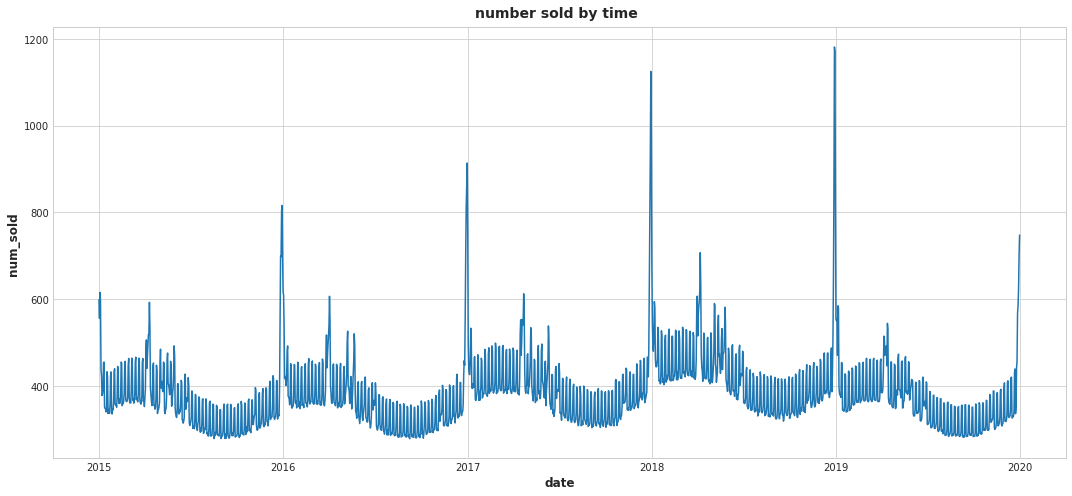

In [302]:
test["num_sold"]= test_pred
frames = [train, test]
data = pd.concat(frames)
##########""
data_plot = data.groupby(['date']).mean().reset_index()
plt.figure(figsize=(15,7))
sns.lineplot(x=data_plot.date, y=data_plot.num_sold,)
plt.title('number sold by time ', fontsize=14)
plt.show()

Looking at the prdicted values ( year of 2019 ) we can see that the baseline could capture the trends in the second quarter and at the end of year

Text(0.5, 1.0, 'Expected Number sold by each store for the year 2019 ')

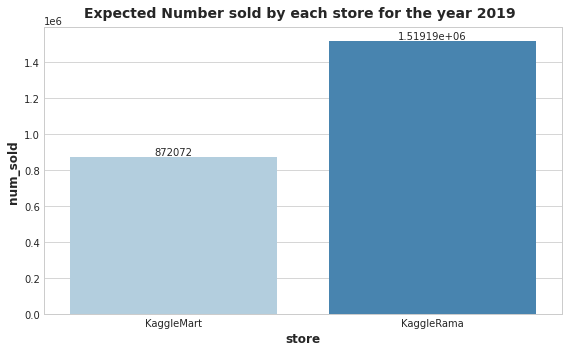

In [303]:
sld_store = test.groupby(['store']).sum().reset_index()
plt.figure(figsize=(8,5))
ax = sns.barplot(x="store", y='num_sold', data=sld_store, palette="Blues")
ax.bar_label(ax.containers[0])
ax.set_title('Expected Number sold by each store for the year 2019 ',
             fontsize = 14)

Looking at the figure above we can say that for the year 2019 ( as it was in previous years ) KaggleRama are the strong condidate to become the official outlet for all things Kaggle.

#### Note 
As mentioned before this is just a baseline for proof of concept , there is still a large room for improvement wether on data ( feature engineering) , or on exprimenting with other models , libraries.Which is  encouraged since the data is quite small. 

<h3 style='background:#11489c; border:0; color:white'><center>I Hope you find this usful , Good Luck</center></h3>